# SXCH

Removed 12 rows where 'COO' == 3
Removed 11 rows where 'Localization' == 3
COO mapping: 1-GCB → 0, 2-nonGCB → 1
Localization mapping: 1-nodal → 0, 2-Extranodal → 1


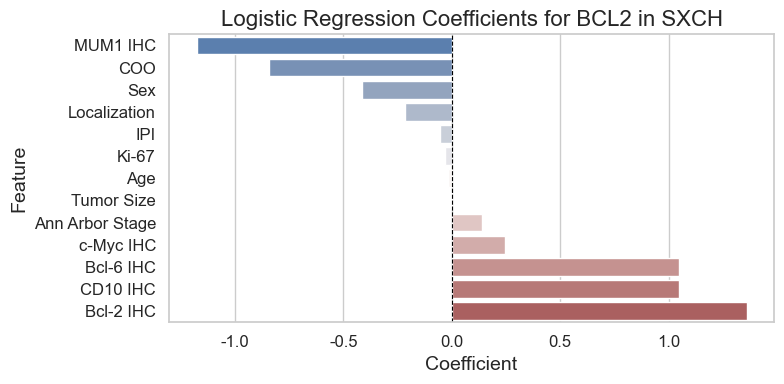

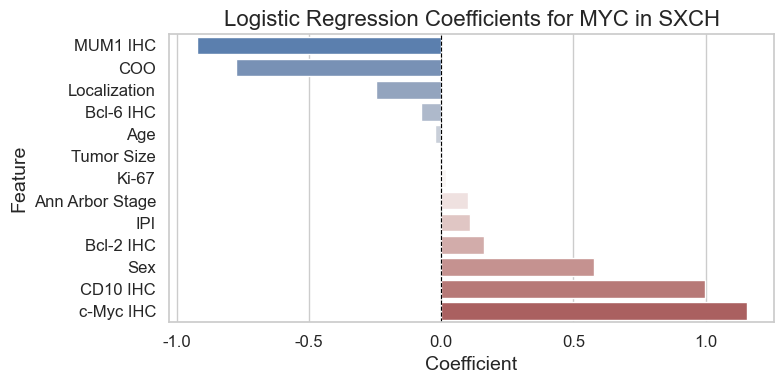

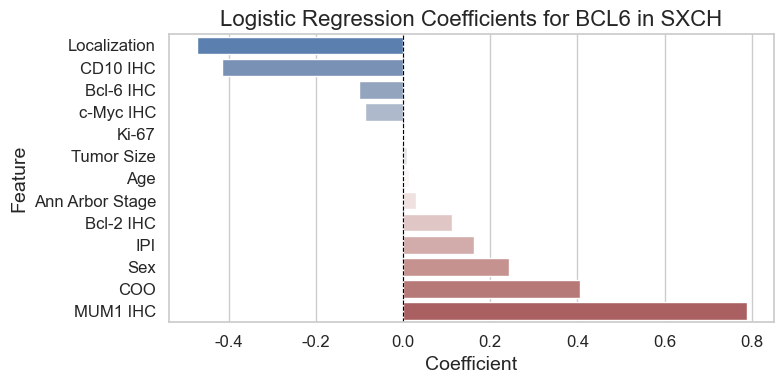

In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
import warnings
from statsmodels.tools.sm_exceptions import PerfectSeparationWarning
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ----------- 全局字体与样式设置 -------------
FONT_SIZES = {
    "ylabel": 14,   # y轴标签
    "xlabel": 14,   # x轴标签
    "xtick": 12,     # x轴刻度
    "ytick": 12,     # y轴刻度
    "legend": 13,   # 图例
    "title": 16     # 标题
}

plt.rcParams['font.family'] = 'Arial'  # ✅ 全局字体 Arial
plt.rcParams['axes.unicode_minus'] = False  # 负号正常显示
plt.rcParams.update({'figure.max_open_warning': 0})

# 1. 读取数据
df = pd.read_excel("/data114_4/chenjy/DLBCL/code/merge_files/SXH_with_mutation(merge).xlsx")

# 2. 重命名部分变量简化处理
col_map = {
    'COO classification(Hans algorithm)--（1-GCB;2-nonGCB;3-unclassified or unknown）': 'COO',
    'localization(1-nodal only;2-Extranodal;3-unknown)': 'Localization',
    'Ann Arbor stage(Ⅰ，ⅡⅢ，Ⅳ，Not fully staged/not known*)': 'Ann Arbor',
    'IPI（0；1；2；3；4；）': 'IPI'
}
df.rename(columns=col_map, inplace=True)

# 3. 删除值为3或3.0的行
for col in ['COO', 'Localization']:
    before = len(df)
    df = df[~df[col].astype(str).isin(['3', '3.0'])]
    after = len(df)
    print(f"Removed {before - after} rows where '{col}' == 3")

# 4. 删除缺失值
df = df.dropna(axis=0, how='any').reset_index(drop=True)

# 5. 将COO和localization映射为0/1
df['COO'] = df['COO'].astype(int).map({1: 0, 2: 1})
df['Localization'] = df['Localization'].astype(int).map({1: 0, 2: 1})
print("COO mapping: 1-GCB → 0, 2-nonGCB → 1")
print("Localization mapping: 1-nodal → 0, 2-Extranodal → 1")

# 6. 变量分类
continuous_vars = ['Ki-67(%)', '肿瘤最大径', '年龄', 'Ann Arbor', 'IPI']
binary_vars = ['性别', 'COO', 'Localization',
               'Bcl-2(0-negative,1-positive≥50%）', 'c-Myc（0-negative,1-positive≥40%）',
               'Bcl-6（0-negative,1-positive≥30%）', 'CD10（0-negative,1-positive≥30%）',
               'MUM1（0-negative,1-positive≥30%）']
               
dependent_vars = ['BCL2', 'MYC', 'BCL6']

# 7. 处理二分类变量为0/1
df_onehot = df.copy()
for col in binary_vars:
    df_onehot[col] = LabelEncoder().fit_transform(df_onehot[col].astype(str))

# 8. 单变量逻辑回归
def univariate_logistic_regression(df, target, continuous_vars, binary_vars):
    results = []
    for var in continuous_vars + binary_vars:
        try:
            X = df[[var]].copy()
            X = sm.add_constant(X)
            y = df[target]
            with warnings.catch_warnings(record=True) as w:
                warnings.simplefilter("always")
                model = sm.Logit(y, X).fit(disp=0)
                for warning in w:
                    if issubclass(warning.category, PerfectSeparationWarning):
                        print(f"Warning for target '{target}', variable '{var}': Perfect separation detected.")
            coef = model.params[var]
            pval = model.pvalues[var]
            OR = np.exp(coef)
            results.append({'Target': target, 'Feature': var, 'Coef': coef, 'Odds Ratio': OR, 'p-value': pval})
        except Exception as e:
            print(f"Error for target '{target}', variable '{var}': {e}")
    return pd.DataFrame(results)

# 9. 执行分析
final_results = []
for target in dependent_vars:
    res = univariate_logistic_regression(df_onehot, target, continuous_vars, binary_vars)
    final_results.append(res)

final_df = pd.concat(final_results, ignore_index=True)
final_df.sort_values(by=['Target', 'p-value'], inplace=True)

feature_rename_dict = {
    'Ki-67(%)': 'Ki-67',
    '肿瘤最大径': 'Tumor Size',
    '年龄': 'Age',
    '性别': 'Sex',
    'Bcl-2(0-negative,1-positive≥50%）': 'Bcl-2 IHC',
    'c-Myc（0-negative,1-positive≥40%）': 'c-Myc IHC',
    'Bcl-6（0-negative,1-positive≥30%）': 'Bcl-6 IHC',
    'CD10（0-negative,1-positive≥30%）': 'CD10 IHC',
    'MUM1（0-negative,1-positive≥30%）': 'MUM1 IHC',
    'Ann Arbor': 'Ann Arbor Stage'
}
final_df['Feature'] = final_df['Feature'].replace(feature_rename_dict)

# --- 绘图 ---
sns.set(style="whitegrid")

save_dir = "/data114_4/chenjy/DLBCL/model/logistic_plot/SXCH"
os.makedirs(save_dir, exist_ok=True)

for target in dependent_vars:
    df_plot = final_df[(final_df["Target"] == target)].copy()
    df_plot["Coef_clipped"] = df_plot["Coef"]
    df_plot = df_plot.sort_values("Coef_clipped", ascending=True)

    plt.figure(figsize=(8, max(4, 0.3 * len(df_plot))))
    ax = sns.barplot(
        x="Coef_clipped",
        y="Feature",
        data=df_plot,
        palette="vlag",
        hue="Feature",
        legend=False
    )

    ax.set_title(f'Logistic Regression Coefficients for {target} in SXCH',
                 fontsize=FONT_SIZES["title"])
    ax.set_xlabel("Coefficient", fontsize=FONT_SIZES["xlabel"])
    ax.set_ylabel("Feature", fontsize=FONT_SIZES["ylabel"])
    ax.tick_params(axis='x', labelsize=FONT_SIZES["xtick"])
    ax.tick_params(axis='y', labelsize=FONT_SIZES["ytick"])

    ax.axvline(0, color="black", linewidth=0.8, linestyle="--")
    
    plt.tight_layout()
    save_path = os.path.join(save_dir, f"{target}_coef_plot.pdf")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


# CHCAMS

Removed 2 rows where 'coo' == 3
Removed 9 rows where 'localization' == 3
coo mapping: 1-GCB → 0, 2-nonGCB → 1
localization mapping: 1-nodal → 0, 2-Extranodal → 1


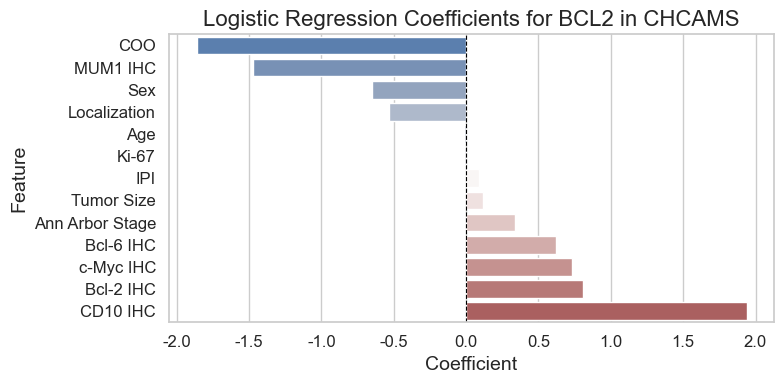

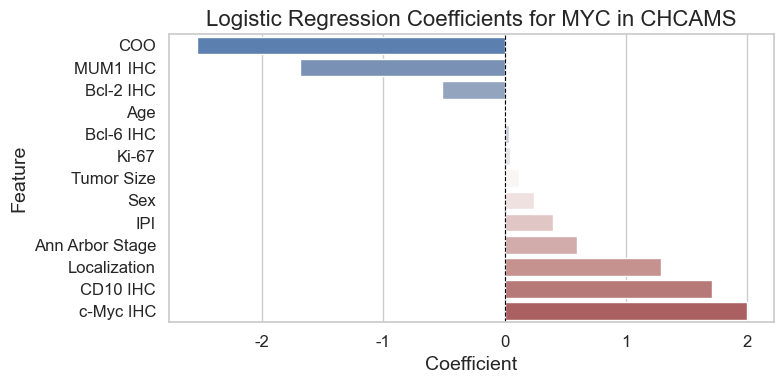

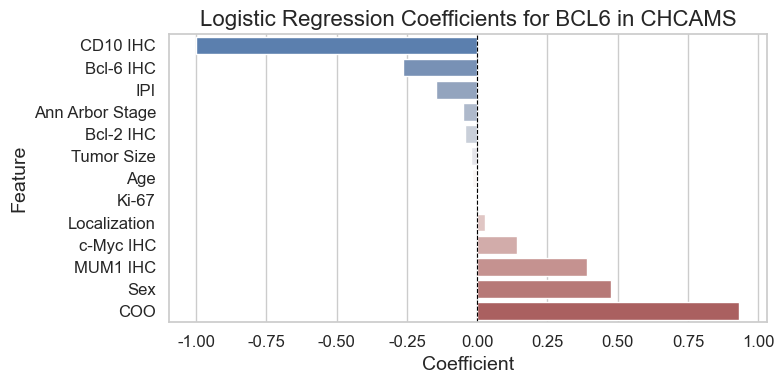

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
import warnings
from statsmodels.tools.sm_exceptions import PerfectSeparationWarning
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. 读取数据
df = pd.read_csv("/data114_4/chenjy/DLBCL/code/TCH_with_clinical.csv")

# 2. 删除 COO 和 localization 中为 3 的行
for col in ['coo', 'localization']:
    before = len(df)
    df = df[~df[col].astype(str).isin(['3', '3.0'])]
    after = len(df)
    print(f"Removed {before - after} rows where '{col}' == 3")

# 3. 删除缺失值
df = df.dropna(axis=0, how='any').reset_index(drop=True)

# 4. 二分类映射（COO, localization）
df['coo'] = df['coo'].astype(int).map({1: 0, 2: 1})
df['localization'] = df['localization'].astype(int).map({1: 0, 2: 1})
print("coo mapping: 1-GCB → 0, 2-nonGCB → 1")
print("localization mapping: 1-nodal → 0, 2-Extranodal → 1")

# 5. 变量分类
dependent_vars = ['BCL2', 'MYC', 'BCL6']

continuous_vars = ['age', 'ki67-ihc', 'd', 'aa stage', 'ipi']
binary_vars = ['sex', 'bcl2-ihc', 'c-Myc-ihc', 'bcl6-ihc', 'cd10-ihc', 'mum1-ihc', 'coo', 'localization']

# 6. 对二分类变量编码
df_model = df.copy()
for col in binary_vars:
    df_model[col] = LabelEncoder().fit_transform(df_model[col].astype(str))

# 7. 单变量 Logistic 回归函数
def univariate_logistic_regression(df, target, continuous_vars, binary_vars):
    results = []
    for var in continuous_vars + binary_vars:
        try:
            X = df[[var]].copy()
            X = sm.add_constant(X)
            y = df[target]
            with warnings.catch_warnings(record=True) as w:
                warnings.simplefilter("always")
                model = sm.Logit(y, X).fit(disp=0)
                for warning in w:
                    if issubclass(warning.category, PerfectSeparationWarning):
                        print(f"Warning for target '{target}', variable '{var}': Perfect separation detected.")
            coef = model.params[var]
            pval = model.pvalues[var]
            OR = np.exp(coef)
            results.append({'Target': target, 'Feature': var, 'Coef': coef, 'Odds Ratio': OR, 'p-value': pval})
        except Exception as e:
            print(f"Error for target '{target}', variable '{var}': {e}")
    return pd.DataFrame(results)

# 8. 执行逻辑回归
final_results = []
for target in dependent_vars:
    res = univariate_logistic_regression(df_model, target, continuous_vars, binary_vars)
    final_results.append(res)

final_df = pd.concat(final_results, ignore_index=True)
final_df.sort_values(by=['Target', 'p-value'], inplace=True)

feature_rename_dict = {
    'ki67-ihc': 'Ki-67',
    'd': 'Tumor Size',
    'age': 'Age',
    'sex': 'Sex',
    'bcl2-ihc': 'Bcl-2 IHC',
    'c-Myc-ihc': 'c-Myc IHC',
    'bcl6-ihc': 'Bcl-6 IHC',
    'cd10-ihc': 'CD10 IHC',
    'mum1-ihc': 'MUM1 IHC',
    'ipi': 'IPI',
    'coo': 'COO',
    'aa stage': 'Ann Arbor Stage',
    'localization': 'Localization',
}
final_df['Feature'] = final_df['Feature'].replace(feature_rename_dict)

# ================= 全局绘图参数 =================
sns.set(style="whitegrid")
plt.rcParams['font.family'] = 'Arial'   # 全局字体 Arial
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams.update({'figure.max_open_warning': 0})

# --- 定义字体大小参数 ---
FONT_SIZES = {
    "ylabel": 14,       # y轴标签
    "xlabel": 14,       # x轴标签
    "xtick": 12,        # x轴刻度
    "ytick": 12,        # y轴刻度
    "legend": 13,       # 图例
    "title": 16         # 标题
}

save_dir = "/data114_4/chenjy/DLBCL/code/logistic_plot/CHCAMS"
os.makedirs(save_dir, exist_ok=True)

for target in dependent_vars:
    df_plot = final_df[(final_df["Target"] == target)].copy()
    df_plot["Coef_clipped"] = df_plot["Coef"]
    df_plot = df_plot.sort_values("Coef_clipped", ascending=True)

    plt.figure(figsize=(8, max(4, 0.3 * len(df_plot))))
    ax = sns.barplot(
        x="Coef_clipped",
        y="Feature",
        data=df_plot,
        palette="vlag",
        hue="Feature",
        legend=False
    )

    ax.set_title(
        f'Logistic Regression Coefficients for {target} in CHCAMS',
        fontsize=FONT_SIZES["title"]
    )
    ax.set_xlabel("Coefficient", fontsize=FONT_SIZES["xlabel"])
    ax.set_ylabel("Feature", fontsize=FONT_SIZES["ylabel"])
    ax.tick_params(axis='x', which='major', labelsize=FONT_SIZES["xtick"])
    ax.tick_params(axis='y', which='major', labelsize=FONT_SIZES["ytick"])

    # 中心参考线
    ax.axvline(0, color="black", linewidth=0.8, linestyle="--")

    plt.tight_layout()
    save_path = os.path.join(save_dir, f"{target}_coef_plot.pdf")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
